In [1]:
from tensorflow import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [9]:
(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()
image_size = x_train_data.shape[1]
original_dim = image_size * image_size
x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])
x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255
input_shape = (original_dim, )
batch_size = 128


In [10]:
def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

In [11]:
def create_model(hidden_node, latent_node):
    # build encoder model
    # input layer
    encoder_inputs = Input(shape=input_shape, name='input_encoder')
    # hidden layer
    encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)

    z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)

    # normalize log variance to std dev
    z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_encoder_inputs = Input(shape=(latent_node,), name='latent_sampling')
    decoder_hidden = Dense(hidden_node, activation='relu')(latent_encoder_inputs)
    decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)

    # instantiate decoder model
    decoder = Model(latent_encoder_inputs, decoder_outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    model_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, model_outputs, name='vae_mlp')
    
    reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    #vae.summary()
    return vae, encoder, decoder

In [12]:
def train_model(model):
    trained_model = model.fit(x_train_data, epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_data, None))
    return trained_model 

In [13]:
def plot_latent_space(encoder):
    z_test, _, _ = encoder.predict(x_test_data, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test_data)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()

In [20]:
def plot_vae_output(decoder,latent_dim):
    n = 20
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]    
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)
            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit
    
    plt.figure(figsize=(10, 10))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    #plt.imshow(figure, cmap='Greens_r')
    plt.imshow(figure)
    plt.savefig("VAE_Output")
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 16)           4112        ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 16)           4112        ['dense_3[0][0]']                
                                                                                            

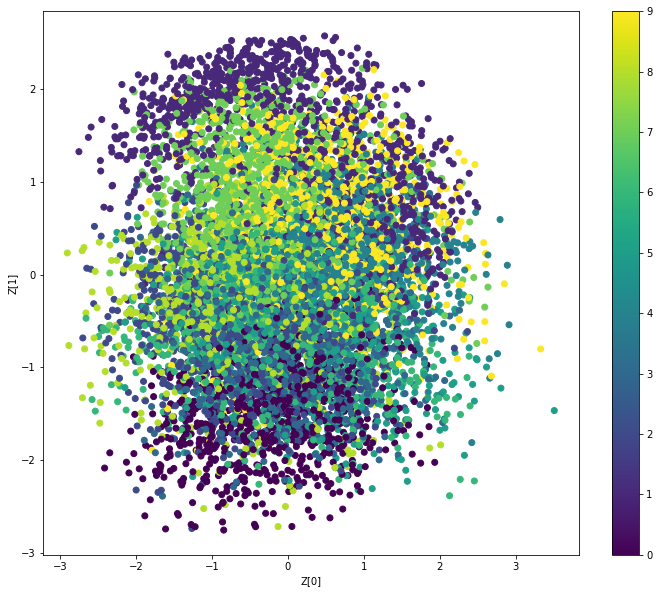

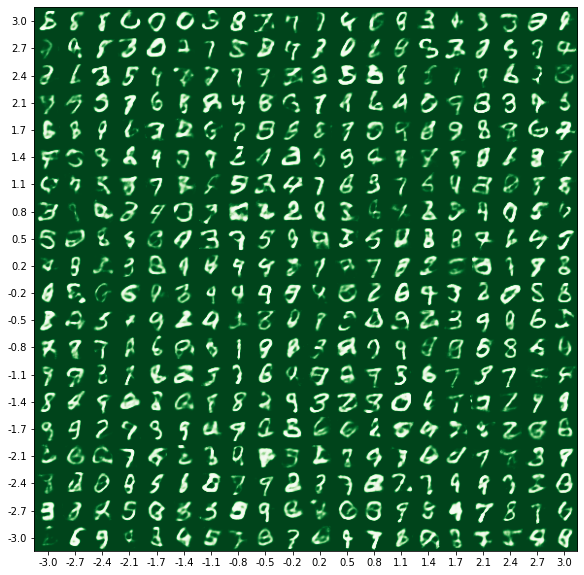

In [15]:
#Create VAE model with 2 code units and generating images by varying each code unit from -3 to 3
intermediate_dim = 256
latent_dim = 16
epochs = 50
vae, encoder, decoder = create_model(intermediate_dim, latent_dim)
trained_model = train_model(vae)


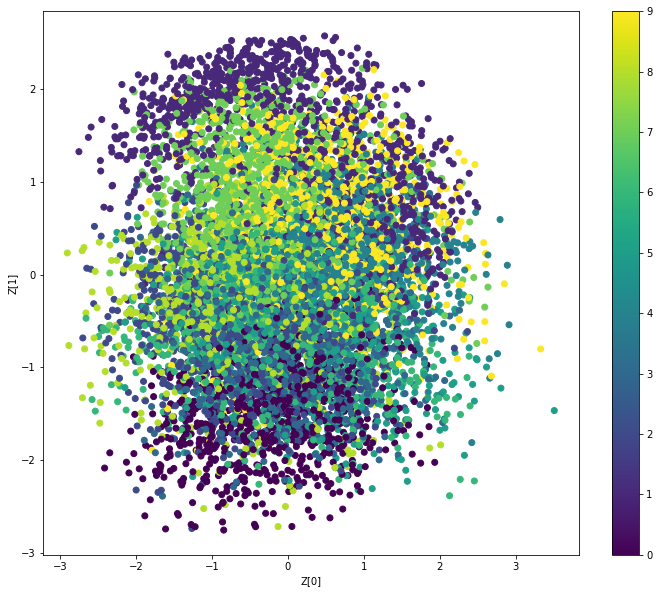

In [17]:
plot_latent_space(encoder)


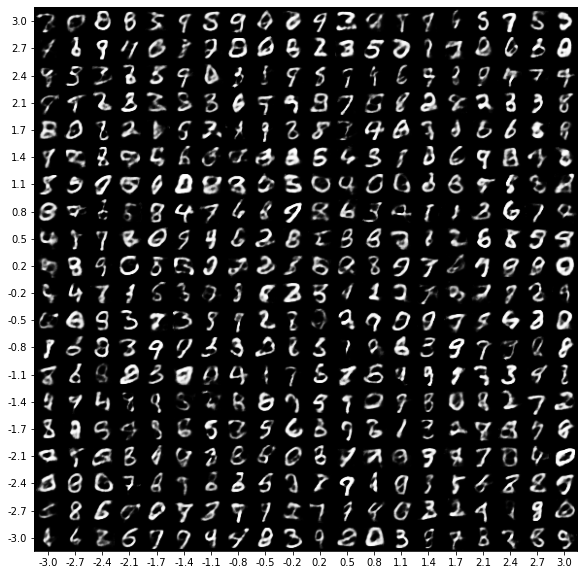

<Figure size 432x288 with 0 Axes>

In [21]:
plot_vae_output(decoder, latent_dim)
plt.gray()